In [47]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_parquet(Path(".") / "data" / "mau.parquet")

In [48]:
l = np.load(Path(".") / "data" / "test_trajectories" / "trajectory_25.npy")
l.shape

(10000, 9)

In [70]:
import chess

b = chess.Board()


b.promoted

0

In [21]:
import chess
import numpy as np
from pathlib import Path


def fix_trajectory(trajectories: np.ndarray):

    def try_next_move(board: chess.Board, moves: list[str], index: int = 0):

        board = board.copy()
        if index >= len(moves):
            return True, []

        move = moves[index]
        if not move:
            return True, []

        # Try the original move first
        try:
            board.push_uci(move)
            valid, rest = try_next_move(board, moves, index + 1)
            if valid:
                return True, [move] + rest
        except chess.IllegalMoveError:
            pass

        # If the move is illegal, try promotion candidates
        for promotion in ['q', 'r', 'n', 'b']:
            candidate = move + promotion
            board_copy = board.copy()
            try:
                board_copy.push_uci(candidate)
            except chess.IllegalMoveError:
                continue

            valid, rest = try_next_move(board_copy, moves, index + 1)
            if valid:
                return True, [candidate] + rest

        return False, None

    depth = 8

    il = 0
    for i_traj, traj in enumerate(trajectories):
        initial_fen = traj[0]
        moves = list(traj[1:])
        board = chess.Board(initial_fen)
        valid, corrected_moves = try_next_move(board, moves)

        if not valid:
            il += 1
        else:
            diff = depth - len(corrected_moves)
            if diff > 0:
                corrected_moves.extend([''] * diff)
            trajectories[i_traj, 1:] = corrected_moves

    print("Invalid trajectories:", il)

def fix_all_trajectories():
    import re

    folder = Path(".") / "data" / "test_trajectories"
    pattern = re.compile(r"trajectory_(\d+)\.npy")

    for ent in folder.iterdir():

        if not ent.is_file():
            continue

        res = re.findall(pattern, ent.name)

        if len(res) == 0:
            continue

        trajectories = np.load(ent)
        fix_trajectory(trajectories)

        np.save(ent, trajectories)

fix_all_trajectories()
# Optionally, save the corrected trajectories back to a numpy file.
# np.save(Path(".") / "data" / "test_trajectories" / "trajectory_28_corrected.npy", np.array(corrected_trajectories, dtype=object))


Invalid trajectories: 2
Invalid trajectories: 0
Invalid trajectories: 0
Invalid trajectories: 2
Invalid trajectories: 0


In [6]:
import numpy as np


ms = []
for i in range(25, 30):
    activations = np.load(f"./data/our_test/root_{i}.npy")
    ms.append((activations > 0.05).mean())

np.mean(ms)

0.21646975748697916

In [19]:
20 * 2 * 2 / (192 * 64)

0.006510416666666667

In [20]:
np.mean(ms) / 0.006510416666666667

33.24975475

In [17]:
il = 0

print(len(corrected_trajectories))

boards = []
for traj in corrected_trajectories:
    b = chess.Board(traj[0])

    for move in traj[1:]:

        if move:

            try:
                b.push_uci(move)
            except chess.IllegalMoveError:

                try:
                    b.push_uci(move + 'q')
                except chess.IllegalMoveError:
                    il += 1
                    boards.append((b, move))
                    break

il

9998


0

In [54]:
n_folder = Path(".") / "data" / "test_trajectories"

n = np.load(n_folder / "trajectory_25.npy")

n.shape

(10000, 9)

In [ ]:

t = 0
for i in range(34):

    k = np.load(Path(".") / "data" / "test_latents" / f"latent_25_{i}.npy")
    t += k.shape[0]

t

10000

In [ ]:
import chess
import chess.svg
from pathlib import Path
import numpy as np


n_folder = Path(".") / "data" / "test_trajectories"
a_folder = Path(".") / "data" / "altered_trajectories"

n = np.load(n_folder / "trajectory_25.npy")[:1_000]
a = np.load(a_folder / "trajectory_25.npy")

def get_svg_sequence(trajectory, board_size=150):
    """
    Given a trajectory (first element is the initial FEN, then UCI moves),
    build and return a list of SVG board images.
    """
    boards_svg = []
    board = chess.Board(trajectory[0])
    boards_svg.append(chess.svg.board(board=board, size=board_size))
    for move_uci in trajectory[1:]:
        if move_uci == "":  # empty string means the game ended
            break
        move = chess.Move.from_uci(move_uci)
        board.push(move)
        boards_svg.append(chess.svg.board(board=board, size=board_size, lastmove=move))
    return boards_svg

html_parts = [
    "<html>",
    "<head>",
    "<meta charset='utf-8'>",
    "<title>Altered Chess Trajectories</title>",
    "<style>",
    "body { font-family: Arial, sans-serif; background-color: #f4f4f4; margin: 20px; }",
    "/* The scroll-container holds all the game boxes horizontally */",
    ".scroll-container { display: flex; overflow-x: auto; }",
    "/* Each game-box is a column showing a pair of trajectories side by side */",
    ".game-box { display: flex; flex-direction: row; border: 1px solid #ddd; border-radius: 8px; margin: 10px; padding: 10px; }",
    "/* Each trajectory is a vertical column of boards */",
    ".trajectory { display: flex; flex-direction: column; margin: 5px; }",
    ".trajectory svg { margin-bottom: 10px; }",
    "</style>",
    "</head>",
    "<body>",
    "<h2>Altered Chess Trajectories</h2>",
    "<div class='scroll-container'>"
]


altered_mask = ((n[:, 1:] != a[:, 1:]).any(axis=1))
si = np.random.choice(np.where(altered_mask)[0], size=5, replace=False)

for i in si:
    traj_normal = n[i]
    traj_altered = a[i]

    svg_normal = get_svg_sequence(traj_normal)
    svg_altered = get_svg_sequence(traj_altered)

    game_html = f"<h3>{i}</h3><div class='game-box'>"

    game_html += "<div class='trajectory'>"
    for svg in svg_normal:
        game_html += svg
    game_html += "</div>"

    game_html += "<div class='trajectory'>"
    for svg in svg_altered:
        game_html += svg
    game_html += "</div>"

    game_html += "</div>"
    html_parts.append(game_html)

html_parts.extend([
    "</div>",
    "</body>",
    "</html>"
])

html_content = "\n".join(html_parts)
output_file = Path("altered_chess_trajectories.html")
_ = output_file.write_text(html_content, encoding="utf-8")


8921

array(['f2f1', 'd8d4', 'a6a5', 'b4b5', 'a5a4', 'g2g3', 'b7b6', 'g3f4'],
      dtype='<U74')

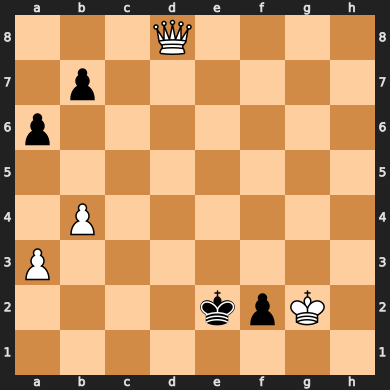

array(['f7f8', 'c5d6', 'd3c3', 'd6e6', 'c3d4', 'e6f7', 'd4c5', 'f7e7'],
      dtype='<U74')

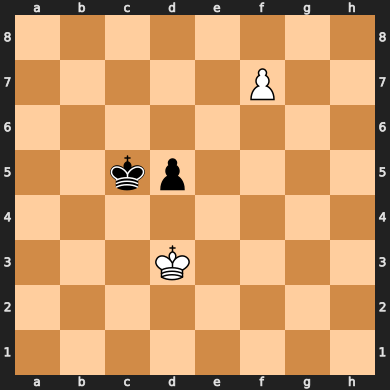

In [12]:
for b, m in ib[:20]:

    display(m)
    display(b)

In [16]:
vc.sample(1).index[0]

(61049, 46189, 106357, 83977, 62006, 23989, 7734)

<Axes: xlabel='mau3'>

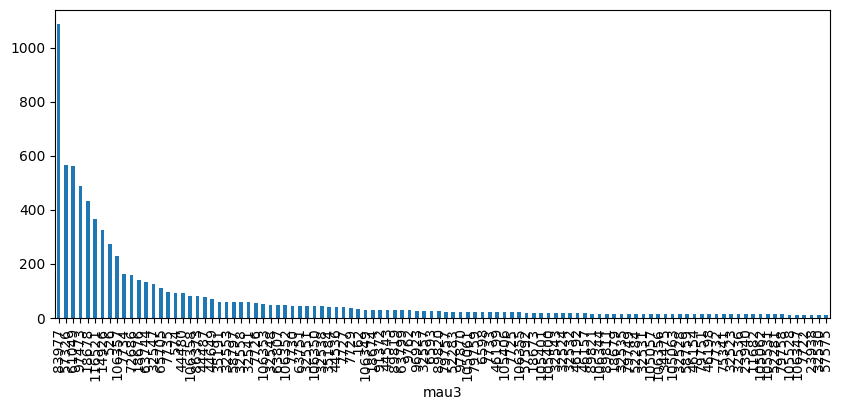

In [41]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

vc = df["mau3"].value_counts()
vc[vc > 10].plot.bar(ax=ax)

In [6]:
value_counts = df['mau1'].value_counts(normalize=True)
sampled_mau = np.random.choice(value_counts.index, p=value_counts.values)
sampled_mau, value_counts[sampled_mau]

(61049, 0.2017)

In [ ]:
import chess

from IPython.display import display_html

mask = df['mau1'] == sampled_mau
positions = df[mask]['fens'].sample(n=min(5, mask.sum()))

cards = []
for fen in positions:

    board = chess.Board(fen)

    html = f"""
    <div style="display:inline-block; margin:10px; text-align:center;">
        {board._repr_svg_()}
    </div>
    """
    cards.append(html)

display_html("".join(cards), raw=True)

. . . . . . . .
p . . . R . k p
. p Q . . . p .
. . p . . . . .
. . . p . . . .
P . . P . P . .
. P P . . . . P
. . . . . . K . <path d="M10.137 21.863q-1.063 0-1.688.727-.617.726-.617 1.992 0 1.258.617 1.992.625.727 1.688.727 1.062 0 1.68-.727.624-.734.624-1.992 0-1.266-.625-1.992-.617-.727-1.68-.727zm3.133-4.945v1.437q-.594-.28-1.204-.43-.601-.148-1.195-.148-1.562 0-2.39 1.055-.82 1.055-.938 3.188.46-.68 1.156-1.04.696-.367 1.531-.367 1.758 0 2.774 1.07 1.023 1.063 1.023 2.899 0 1.797-1.062 2.883-1.063 1.086-2.828 1.086-2.024 0-3.094-1.547-1.07-1.555-1.07-4.5 0-2.766 1.312-4.406 1.313-1.649 3.524-1.649.593 0 1.195.117.61.118 1.266.352z" /> <path d="M10.137 21.863q-1.063 0-1.688.727-.617.726-.617 1.992 0 1.258.617 1.992.625.727 1.688.727 1.062 0 1.68-.727.624-.734.624-1.992 0-1.266-.625-1.992-.617-.727-1.68-.727zm3.133-4.945v1.437q-.594-.28-1.204-.43-.601-.148-1.195-.148-1.562 0-2.39 1.055-.82 1.055-.938 3.188.46-.68 1.156-1.04.696-.367 1.531-.367 1.758 0 2.774 1.07 1.023 1.063 1.023 2.899 0 1.797-1.062 2.883-1.063 1.086-2.828 1.086-2.024 0-3.094-1.547-1.07-1.555-1.07-4.5 0-2.766 1.312-4.406 1.313-1.649 3.524-1.649.593 0 1.195.117.61.118 1.266.352z" /> <path d="M10 22.785q-1.125 0-1.773.602-.641.601-.641 1.656t.64 1.656q.649.602 1.774.602t1.773-.602q.649-.61.649-1.656 0-1.055-.649-1.656-.64-.602-1.773-.602zm-1.578-.672q-1.016-.25-1.586-.945-.563-.695-.563-1.695 0-1.399.993-2.211 1-.813 2.734-.813 1.742 0 2.734.813.993.812.993 2.21 0 1-.57 1.696-.563.695-1.571.945 1.14.266 1.773 1.04.641.773.641 1.89 0 1.695-1.04 2.602-1.03.906-2.96.906t-2.969-.906Q6 26.738 6 25.043q0-1.117.64-1.89.641-.774 1.782-1.04zm-.578-2.492q0 .906.562 1.414.57.508 1.594.508 1.016 0 1.586-.508.578-.508.578-1.414 0-.906-.578-1.414-.57-.508-1.586-.508-1.023 0-1.594.508-.562.508-.562 1.414z" /> <path d="M10 22.785q-1.125 0-1.773.602-.641.601-.641 1.656t.64 1.656q.649.602 1.774.602t1.773-.602q.649-.61.649-1.656 0-1.055-.649-1.656-.64-.602-1.773-.602zm-1.578-.672q-1.016-.25-1.586-.945-.563-.695-.563-1.695 0-1.399.993-2.211 1-.813 2.734-.813 1.742 0 2.734.813.993.812.993 2.21 0 1-.57 1.696-.563.695-1.571.945 1.14.266 1.773 1.04.641.773.641 1.89 0 1.695-1.04 2.602-1.03.906-2.96.906t-2.969-.906Q6 26.738 6 25.043q0-1.117.64-1.89.641-.774 1.782-1.04zm-.578-2.492q0 .906.562 1.414.57.508 1.594.508 1.016 0 1.586-.508.578-.508.578-1.414 0-.906-.578-1.414-.57-.508-1.586-.508-1.023 0-1.594.508-.562.508-.562 1.414z" /> 
 
 
 
 . r . . . r k .
p . . . p p . p
b p . p . b . P
. . . . . . . .
. . . P . B . p
. . P . . B . .
P . . . . P P .
. R . . R . K . <path d="M10.137 21.863q-1.063 0-1.688.727-.617.726-.617 1.992 0 1.258.617 1.992.625.727 1.688.727 1.062 0 1.68-.727.624-.734.624-1.992 0-1.266-.625-1.992-.617-.727-1.68-.727zm3.133-4.945v1.437q-.594-.28-1.204-.43-.601-.148-1.195-.148-1.562 0-2.39 1.055-.82 1.055-.938 3.188.46-.68 1.156-1.04.696-.367 1.531-.367 1.758 0 2.774 1.07 1.023 1.063 1.023 2.899 0 1.797-1.062 2.883-1.063 1.086-2.828 1.086-2.024 0-3.094-1.547-1.07-1.555-1.07-4.5 0-2.766 1.312-4.406 1.313-1.649 3.524-1.649.593 0 1.195.117.61.118 1.266.352z" /> <path d="M10.137 21.863q-1.063 0-1.688.727-.617.726-.617 1.992 0 1.258.617 1.992.625.727 1.688.727 1.062 0 1.68-.727.624-.734.624-1.992 0-1.266-.625-1.992-.617-.727-1.68-.727zm3.133-4.945v1.437q-.594-.28-1.204-.43-.601-.148-1.195-.148-1.562 0-2.39 1.055-.82 1.055-.938 3.188.46-.68 1.156-1.04.696-.367 1.531-.367 1.758 0 2.774 1.07 1.023 1.063 1.023 2.899 0 1.797-1.062 2.883-1.063 1.086-2.828 1.086-2.024 0-3.094-1.547-1.07-1.555-1.07-4.5 0-2.766 1.312-4.406 1.313-1.649 3.524-1.649.593 0 1.195.117.61.118 1.266.352z" /> <path d="M10 22.785q-1.125 0-1.773.602-.641.601-.641 1.656t.64 1.656q.649.602 1.774.602t1.773-.602q.649-.61.649-1.656 0-1.055-.649-1.656-.64-.602-1.773-.602zm-1.578-.672q-1.016-.25-1.586-.945-.563-.695-.563-1.695 0-1.399.993-2.211 1-.813 2.734-.813 1.742 0 2.734.813.993.812.993 2.21 0 1-.57 1.696-.563.695-1.571.945 1.14.266 1.773 1.04.641.773.641 1.89 0 1.695-1.04 2.602-1.03.906-2.96.906t-2.969-.906

In [34]:
l = np.random.randint(0, 10, (2, 6))
l

array([[5, 1, 5, 0, 6, 9],
       [7, 1, 4, 1, 1, 3]])

In [36]:
import numpy as np

l = np.random.randint(0, 10, (2, 6))

# Step 1: Get indices of top 3 values per row (unsorted)
part_indices = np.argpartition(-l, 3, axis=1)[:, :3]
row_inds = np.arange(l.shape[0])[:, np.newaxis]

# Step 2: Sort those top 3 indices by the actual values
sorted_order = np.argsort(-l[row_inds, part_indices], axis=1)
top_indices = part_indices[row_inds, sorted_order]

# Step 3: Get the sorted top values
top_values = l[row_inds, top_indices]

# Output
print("Original array:\n", l)
print("Top 3 sorted values:\n", top_values)
print("Top 3 indices (sorted by value):\n", top_indices)

Original array:
 [[2 5 0 2 0 0]
 [9 2 7 7 7 3]]
Top 3 sorted values:
 [[5 2 2]
 [9 7 7]]
Top 3 indices (sorted by value):
 [[1 3 0]
 [0 4 2]]


In [8]:
df.loc[df["mau"] > 1000, "mau"]

0        52282
1        32537
2        14926
3        61049
4        91372
         ...  
9995     18678
9996    106353
9997     18678
9998     18678
9999     18678
Name: mau, Length: 9984, dtype: int64